# Example 1 - Wellhead Protection Area (WHPA)
- All the details about the example can be found in [1], and the code in `skbel/examples/demo.py`.
- It concerns a hydrogeological experiment consisting of predicting the wellhead protection area (WHPA) around a pumping well from measured breakthrough curves at said pumping well.
- Predictor and target are generated through forward modeling from a set of hydrogeological model with different hydraulic conductivity fields (not shown).
- The predictor is the set of breakthrough curves coming from 6 different injection wells around the pumping well.
- The target is the WHPA.

For this example, the data is already pre-processed. We are working with 400 examples of both `d` and `h` and consider one extra pair to be predicted. See details in the reference.

[1] [Thibaut, R., Laloy, E., Hermans, T., 2021. A new framework for experimental design using Bayesian Evidential Learning: the case of wellhead protection area. Journal of Hydrology](https://doi.org/10.1016/j.jhydrol.2021.126903)

The pre-print is freely available on arXiv [arXiv:2105.05539](https://arxiv.org/abs/2105.05539)

In [1]:
import os
from os.path import join as jp

import pandas as pd

from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

import demo_visualization as myvis

from skbel.learning.bel import BEL

#### Load the dataset
- The example dataset is saved as pandas DataFrame in `skbel/examples/dataset`.
- An arbitrary choice has to be made on the number of PC to keep for the predictor and the target. In this case, they are set to 50 and 30, respectively.
- The CCA operator `cca` is set to keep the maximum number of CV possible (30).
- The variable `y_test` is the unknown target to predict. It is ignored during the training.

In [2]:
data_dir = jp(os.getcwd(), "dataset")
# Directory in which to unload forecasts and save figures
sub_dir = jp(os.getcwd(), "results")

X_train = pd.read_pickle(jp(data_dir, "X_train.pkl"))
X_test = pd.read_pickle(jp(data_dir, "X_test.pkl"))
y_train = pd.read_pickle(jp(data_dir, "y_train.pkl"))
y_test = pd.read_pickle(jp(data_dir, "y_test.pkl"))

Let's have a look at the dataset.

##### Predictor
The first figure is the whole training set and the test set in thick lines. The latter is highlighted on the second figure.

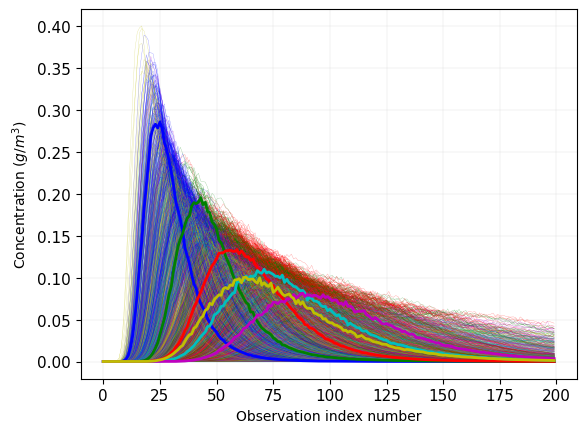

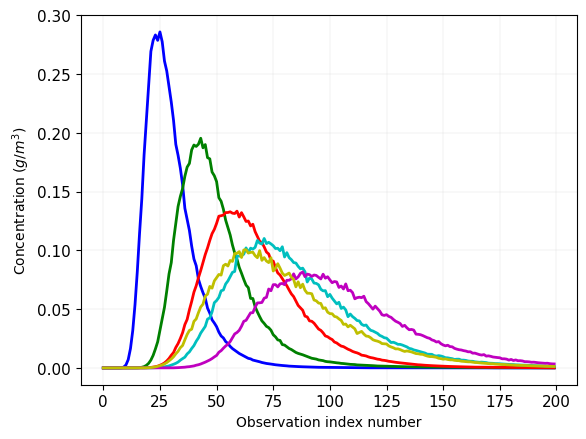

In [3]:
myvis.plot_predictor(X=X_train, X_obs=X_test, base_dir=sub_dir, show=True)

##### Target

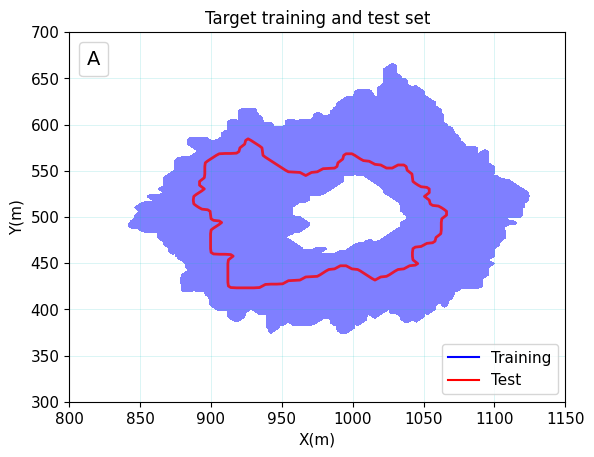

In [4]:
myvis.plot_target(Y=y_train, Y_obs=y_test, base_dir=sub_dir, show=True)

#### Building the BEL model
In this package, a BEL model consists of a succession of Pipelines (imported from scikit-learn).

- The ```X_pre_processing``` and ```Y_pre_processing``` objects are pipelines which will first scale the data for predictor and target, then apply the dimension reduction through PCA.

- The ```X_post_processing``` and ```Y_post_processing``` objects are pipelines which will normalize predictor and target CV's.

- Finally, the BEL model is constructed by passing as arguments all these pipelines in the `BEL` object.

In [5]:
# Pipeline before CCA
X_pre_processing = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=50)),
    ]
)
Y_pre_processing = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        ("pca", PCA(n_components=30)),
    ]
)

# Canonical Correlation Analysis
cca = CCA(n_components=30)

# Pipeline after CCA
X_post_processing = Pipeline(
    [("normalizer", PowerTransformer(method="yeo-johnson", standardize=True))]
)
Y_post_processing = Pipeline(
    [("normalizer", PowerTransformer(method="yeo-johnson", standardize=True))]
)

# Initiate BEL object
bel_model = BEL(
    X_pre_processing=X_pre_processing,
    X_post_processing=X_post_processing,
    Y_pre_processing=Y_pre_processing,
    Y_post_processing=Y_post_processing,
    regression_model=cca,
)

#### Set model parameters

In [6]:
bel_model.mode = "mvn"  # How to compute the posterior conditional distribution
# Save original dimensions of both predictor and target
bel_model.X_shape = (6, 200)  # Six curves with 200 time steps each
bel_model.Y_shape = (100, 87)  # 100 rows and 87 columns
# Number of samples to be extracted from the posterior distribution
bel_model.n_posts = 400

#### Train the model

In [7]:
# Fit BEL model
bel_model.fit(X=X_train, Y=y_train);

#### Infer the posterior distribution

Now that the BEL model is fitted, we can sample WHPA from the inferred posterior distribution using the chosen method (MVN, KDE or transport maps).
The sampling occurs in canonical space, so we have to inverse transform the samples and reshape them.

In [8]:
%%capture
# The posterior distribution is computed within the method below.
forecast_posterior = bel_model.predict(X_test.array.reshape(1, -1))
forecast_posterior = forecast_posterior.reshape((-1, 100, 87))  # Reshape to original dimension

Let's visualise the results:

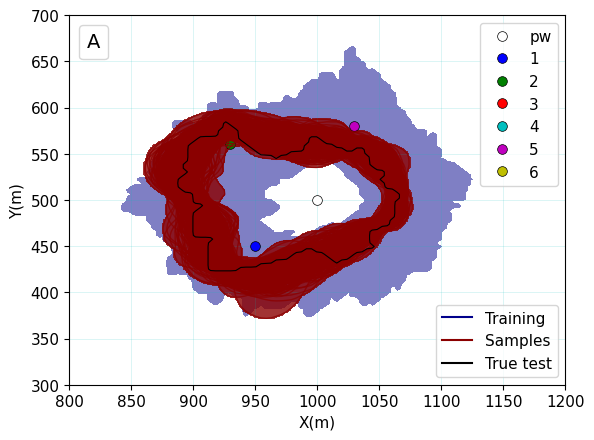

In [9]:
myvis.plot_posterior(forecast_posterior=forecast_posterior, Y=y_train, Y_obs=y_test, base_dir=sub_dir, show=True)